# Import Required Libraries

In [1]:
!pip install contractions
!pip install --upgrade imbalanced-learn scikit-learn
!pip install shap
!pip install spacy

!python -m spacy download en_core_web_sm
!pip install tensorflow
!pip install textblob
!pip install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import numpy as np
import pandas as pd
import textstat
import string

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Data balancing
from imblearn.over_sampling import SMOTE

# Sklearn libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
)
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix


# NLTK libraries
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
import contractions
from nltk.sentiment.vader import SentimentIntensityAnalyzer


import spacy
nlp = spacy.load("en_core_web_sm")


# NLTK resource downloads
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')


import spacy
from textblob import TextBlob
from collections import Counter
import pandas as pd
import spacy
from collections import Counter


[nltk_data] Downloading package words to
[nltk_data]     /Users/sandhiyadhanasekaran/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sandhiyadhanasekaran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sandhiyadhanasekaran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sandhiyadhanasekaran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sandhiyadhanasekaran/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Load in Datasets


In [3]:
def load_file(filepath):
    return pd.read_csv(filepath, header=None, names=['text'])

In [4]:

# Training df
df_train = load_file('/Users/sandhiyadhanasekaran/Downloads/raw_data/fulltrain.csv')
df_train['label'] = df_train.index

# Testing df
df_test = load_file('/Users/sandhiyadhanasekaran/Downloads/raw_data/balancedtest.csv')
df_test['label'] = df_test.index

# Map the labels

In [5]:
label_mapping = {
    1: "Satire",
    2: "Hoax",
    3: "Propaganda",
    4: "Reliable News"
}
df_train['label'] = df_train['label'].map(label_mapping)
df_test['label'] = df_test['label'].map(label_mapping)


# Verify datasets loaded in correctly

In [6]:

df_train.head(10) # Training set

,text,label
1,"A little less than a decade ago, hockey fans w...",Satire
1,The writers of the HBO series The Sopranos too...,Satire
1,Despite claims from the TV news outlet to offe...,Satire
1,After receiving 'subpar' service and experienc...,Satire
1,After watching his beloved Seattle Mariners pr...,Satire
1,"At a cafeteria-table press conference Monday, ...",Satire
1,Stunned shock and dismay were just a few of th...,Satire
1,"Speaking with reporters before a game Monday, ...",Satire
1,Sports journalists and television crews were p...,Satire
1,"SALEM, VAF;or the eighth straight world-histor...",Satire


In [7]:
df_test.head(10) # Test set

,text,label
1,When so many actors seem content to churn out ...,Satire
1,In what football insiders are calling an unex...,Satire
1,In a freak accident following Game 3 of the N....,Satire
1,North Koreas official news agency announced to...,Satire
1,The former Alaska Governor Sarah Palin would b...,Satire
1,With the first Presidential debate just two da...,Satire
1,"There are fans, and then there are super-fans....",Satire
1,"With its landmark decisions this week, the Uni...",Satire
1,Koch Industries is defending its acquisition o...,Satire
1,Republican lawmakers asked increasingly tough ...,Satire


# Label distribution

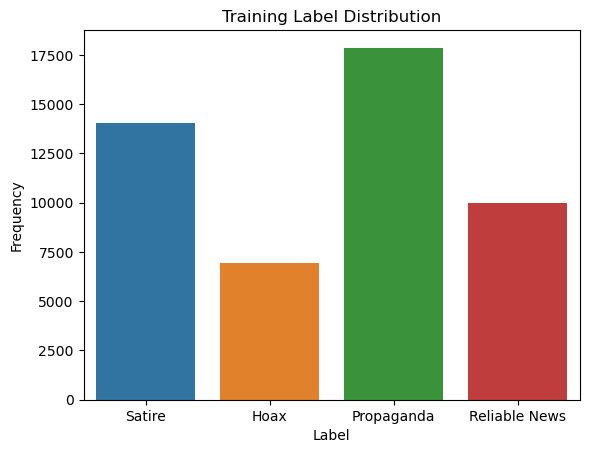

Propaganda       17870
Satire           14047
Reliable News     9995
Hoax              6942
Name: label, dtype: int64

In [8]:
sns.countplot(x='label', data=df_train)
plt.title('Training Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
df_train["label"].value_counts()

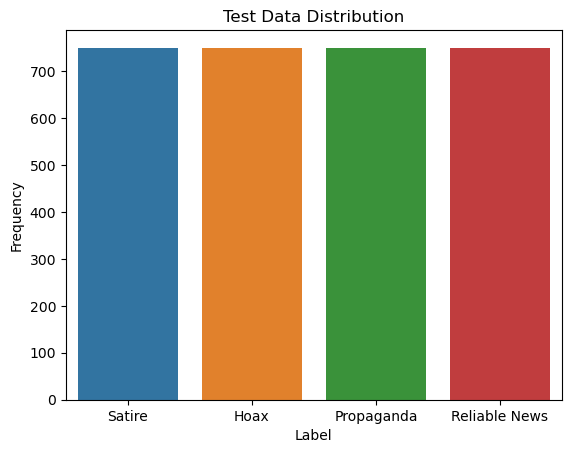

Satire           750
Hoax             750
Propaganda       750
Reliable News    750
Name: label, dtype: int64

In [9]:
sns.countplot(x='label', data=df_test)
plt.title('Test Data Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
df_test["label"].value_counts()

# Basic Text Preprocessing

## Expand Contractions

In [10]:
def expand_contractions(corpus):
    return contractions.fix(corpus)

## Removal of Stop Words

In [11]:
def remove_stopwords(corpus):
    stop = nltk.corpus.stopwords.words('english')
    sentence = ""
    for word in corpus.split():
        if word not in stop:
            sentence += word
            sentence += " "
    return sentence.strip()

## Lemmitization with WordNetLemmitizer

In [12]:
def lemmatize_word(corpus):
    lemma = WordNetLemmatizer()
    sentence = ""
    for word in corpus.split():
        sentence += lemma.lemmatize(word)
        sentence += " "
    return sentence.strip()

## Preprocess the text

In [13]:
def preprocess_text(text):
    text_contractions_expanded = expand_contractions(text)
    text_no_stopwords = remove_stopwords(text_contractions_expanded)
    text_processed = lemmatize_word(text_no_stopwords)
    return text_processed

In [14]:
# Processing datasets
print("Processing dataset: df_train")
df_train['processed_text'] = df_train['text'].apply(preprocess_text)
print("Finished processing dataset: df_train")

print("Processing dataset: df_test")
df_test['processed_text'] = df_test['text'].apply(preprocess_text)
print("Finished processing dataset: df_test")

Processing dataset: df_train
Finished processing dataset: df_train
Processing dataset: df_test
Finished processing dataset: df_test


## Vectorizer- tfidf


In [15]:

sid = SentimentIntensityAnalyzer()
df_train['sentiment_score'] = df_train['processed_text'].apply(lambda text: sid.polarity_scores(text)['compound'])
df_train['sentiment_score'] = df_train['sentiment_score'].astype(str)


X_train_features = df_train['processed_text'] + ' '+ df_train['sentiment_score']

In [16]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

X_train_counts = tfidf_vectorizer.fit_transform(X_train_features)

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_counts.toarray())

X_train, X_val, y_train, y_val= train_test_split(X_train_pca, df_train['label'], test_size=0.2, random_state=42)


# simple neural network

In [18]:
#without oversampled
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# simple feedforward neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # Assuming 4 classes for classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the neural network
model.fit(X_train, y_train_encoded, epochs=30, batch_size=32, validation_split=0.2)


y_train_pred = np.argmax(model.predict(X_train), axis=1)


# Calculate accuracy for training and test datasets
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
print("Train Accuracy:", train_accuracy)


Epoch 1/30


/Users/sandhiyadhanasekaran/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


978/978 ━━━━━━━━━━━━━━━━━━━━ 2s 981us/step - accuracy: 0.8120 - loss: 0.4615 - val_accuracy: 0.9442 - val_loss: 0.1632
Epoch 2/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - accuracy: 0.9444 - loss: 0.1595 - val_accuracy: 0.9497 - val_loss: 0.1392
Epoch 3/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - accuracy: 0.9579 - loss: 0.1261 - val_accuracy: 0.9496 - val_loss: 0.1368
Epoch 4/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step - accuracy: 0.9641 - loss: 0.1018 - val_accuracy: 0.9522 - val_loss: 0.1399
Epoch 5/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step - accuracy: 0.9669 - loss: 0.0935 - val_accuracy: 0.9614 - val_loss: 0.1193
Epoch 6/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step - accuracy: 0.9738 - loss: 0.0788 - val_accuracy: 0.9551 - val_loss: 0.1299
Epoch 7/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - accuracy: 0.9749 - loss: 0.0740 - val_accuracy: 0.9587 - val_loss: 0.1291
Epoch 8/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - accuracy: 0.9800 - loss: 0.0598 - val_accurac

In [19]:
# snn Evaluate the model
sid = SentimentIntensityAnalyzer()
df_test['sentiment_score'] = df_test['processed_text'].apply(lambda text: sid.polarity_scores(text)['compound'])
df_test['sentiment_score'] = df_test['sentiment_score'].astype(str)

#Concatenate features for vectorization
X_test_features = df_test['processed_text'] + ' '+ df_test['sentiment_score']

In [20]:
X_test_vectorized = tfidf_vectorizer.transform(X_test_features)
X_test_pca = pca.transform(X_test_vectorized.toarray())


y_test_pred =np.argmax(model.predict(X_test_pca),axis=1)

y_test_encoded = label_encoder.transform(df_test['label'])

# Calculate accuracy for the test dataset
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

print("Test Accuracy:", test_accuracy)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test Accuracy: 0.7316666666666667


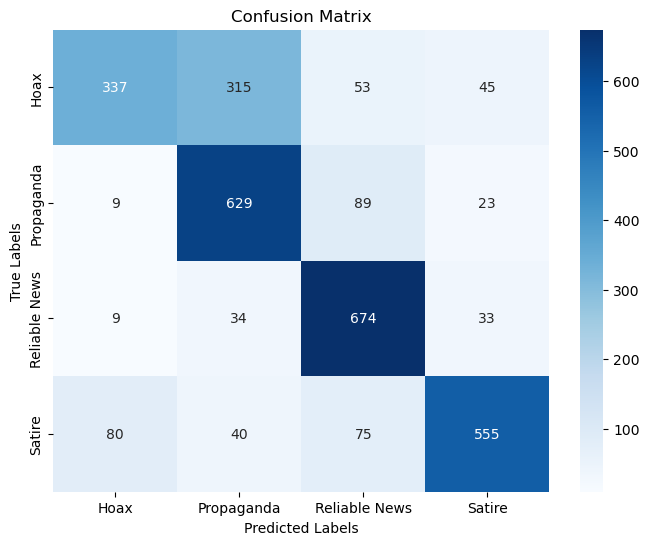

In [21]:
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
from sklearn.metrics import classification_report

# Calculate the classification report
report = classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
               precision    recall  f1-score   support

         Hoax       0.77      0.45      0.57       750
   Propaganda       0.62      0.84      0.71       750
Reliable News       0.76      0.90      0.82       750
       Satire       0.85      0.74      0.79       750

     accuracy                           0.73      3000
    macro avg       0.75      0.73      0.72      3000
 weighted avg       0.75      0.73      0.72      3000



# Cnn

In [28]:
#undersample
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

maxlen = 100  # Maximum sequence length
X_train_padded = pad_sequences(X_train, maxlen=maxlen, padding='post')


# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)


# Reshape data for 1D CNN input
X_train_padded = X_train_padded.reshape(X_train_padded.shape[0], X_train_padded.shape[1], 1)



# Build a simple feedforward neural network
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(128, 5, activation='relu', input_shape=(maxlen, 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # Assuming 4 classes for classification
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the neural network
model.fit(X_train, y_train_encoded, epochs=30, batch_size=32, validation_split=0.2)


y_train_pred = np.argmax(model.predict(X_train), axis=1)
# y_test_pred = np.argmax(model.predict(X_test_processed), axis=1)

# Calculate accuracy for training and test datasets
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
print("Train Accuracy:", train_accuracy)


Epoch 1/30


/Users/sandhiyadhanasekaran/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


978/978 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4351 - loss: 1.2551 - val_accuracy: 0.5079 - val_loss: 1.1571
Epoch 2/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5179 - loss: 1.1380 - val_accuracy: 0.5653 - val_loss: 1.0723
Epoch 3/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5753 - loss: 1.0371 - val_accuracy: 0.6441 - val_loss: 0.9108
Epoch 4/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.6700 - loss: 0.8754 - val_accuracy: 0.6980 - val_loss: 0.8191
Epoch 5/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7152 - loss: 0.7698 - val_accuracy: 0.7389 - val_loss: 0.7172
Epoch 6/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7411 - loss: 0.7001 - val_accuracy: 0.7591 - val_loss: 0.6726
Epoch 7/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7539 - loss: 0.6632 - val_accuracy: 0.6889 - val_loss: 0.8125
Epoch 8/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7644 - loss: 0.6320 - val_accuracy: 0.7699 - val_

In [29]:
#cnnEvaluate the model

#Add sentiment scores and text lengths as additional features
sid = SentimentIntensityAnalyzer()
df_test['sentiment_score'] = df_test['processed_text'].apply(lambda text: sid.polarity_scores(text)['compound'])
df_test['sentiment_score'] = df_test['sentiment_score'].astype(str)


#Concatenate features for vectorization
X_test_features = df_test['processed_text'] + ' '+ df_test['sentiment_score']

# Vectorize the text in the test dataset using the same vectorizer as used for training
X_test_vectorized = tfidf_vectorizer.transform(X_test_features)
X_test_pca = pca.transform(X_test_vectorized.toarray())

# Predict labels for the test dataset
y_test_pred =np.argmax(model.predict(X_test_pca),axis=1)

# Encode the actual labels in the test dataset
y_test_encoded = label_encoder.transform(df_test['label'])

# Calculate accuracy for the test dataset
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

print("Test Accuracy:", test_accuracy)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Accuracy: 0.6596666666666666


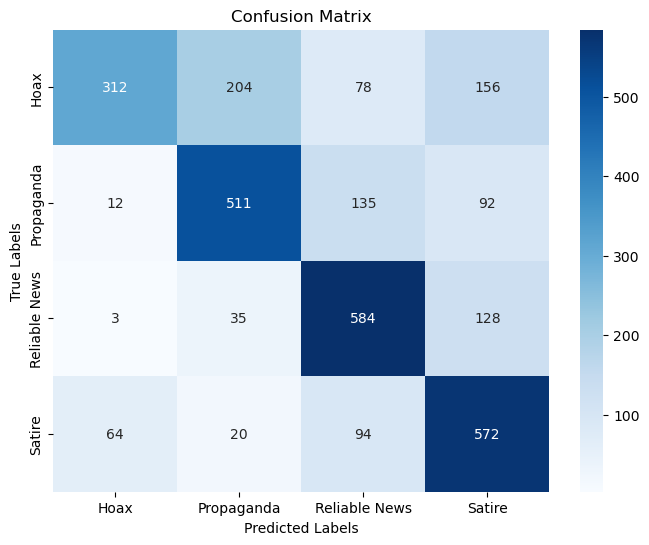

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# CNN-LSTM

In [36]:
#undersample
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

maxlen = 100  # Maximum sequence length
X_train_padded = pad_sequences(X_train, maxlen=maxlen, padding='post')


# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)


# Reshape data for 1D CNN input
X_train_padded = X_train_padded.reshape(X_train_padded.shape[0], X_train_padded.shape[1], 1)


model = Sequential()
model.add(Conv1D(128, 5, activation='relu', input_shape=(maxlen, 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(2))
model.add(LSTM(64))  # LSTM layer after CNN layers
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Assuming 4 classes for classification


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the neural network
model.fit(X_train, y_train_encoded, epochs=30, batch_size=32, validation_split=0.2)


y_train_pred = np.argmax(model.predict(X_train), axis=1)
# y_test_pred = np.argmax(model.predict(X_test_processed), axis=1)

# Calculate accuracy for training and test datasets
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
print("Train Accuracy:", train_accuracy)


Epoch 1/30


/Users/sandhiyadhanasekaran/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


978/978 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.4856 - loss: 1.1734 - val_accuracy: 0.6870 - val_loss: 0.8656
Epoch 2/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7789 - loss: 0.5887 - val_accuracy: 0.8470 - val_loss: 0.4371
Epoch 3/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8377 - loss: 0.4470 - val_accuracy: 0.8380 - val_loss: 0.4392
Epoch 4/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8527 - loss: 0.4090 - val_accuracy: 0.8006 - val_loss: 0.5256
Epoch 5/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8526 - loss: 0.4035 - val_accuracy: 0.8687 - val_loss: 0.3585
Epoch 6/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8721 - loss: 0.3540 - val_accuracy: 0.8558 - val_loss: 0.4004
Epoch 7/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.8756 - loss: 0.3425 - val_accuracy: 0.8805 - val_loss: 0.3312
Epoch 8/30
978/978 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.8778 - loss: 0.3366 - val_accurac

In [37]:
#cnn-lstm Evaluate the model

# Add sentiment scores and text lengths as additional features
sid = SentimentIntensityAnalyzer()
df_test['sentiment_score'] = df_test['processed_text'].apply(lambda text: sid.polarity_scores(text)['compound'])
df_test['sentiment_score'] = df_test['sentiment_score'].astype(str)

# Concatenate features for vectorization
X_test_features = df_test['processed_text'] + ' '+ df_test['sentiment_score']
# Vectorize the text in the test dataset using the same vectorizer as used for training
X_test_vectorized = tfidf_vectorizer.transform(X_test_features)
X_test_pca = pca.transform(X_test_vectorized.toarray())

# Predict labels for the test dataset
y_test_pred =np.argmax(model.predict(X_test_pca),axis=1)

# Encode the actual labels in the test dataset
y_test_encoded = label_encoder.transform(df_test['label'])

# Calculate accuracy for the test dataset
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

print("Test Accuracy:", test_accuracy)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test Accuracy: 0.6816666666666666


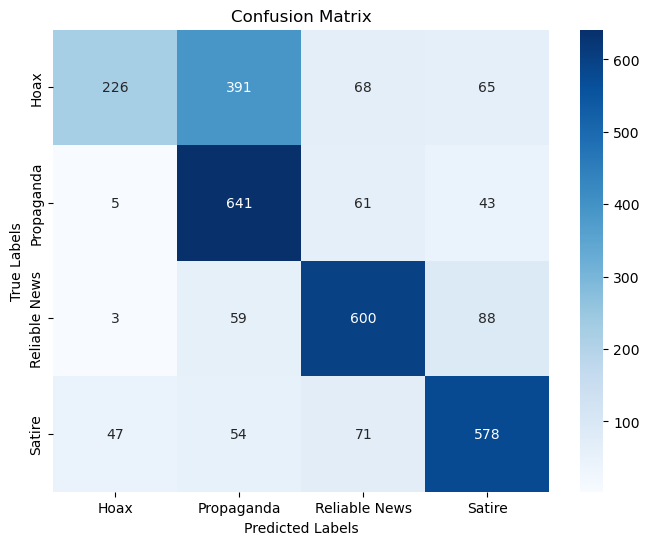

In [38]:
#Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()